# Deep Learning
## HW4 - Problem 1


> Sequence-To-Sequence (Seq2Seq) Models



Name: **Amin Robatian**

Student Number: **400301075**

The following two papers are very helpful for doing this exercise:


*   [1] Sequence to Sequence Learning with Neural Networks  (arXiv:1409.3215)
*    [2] Neural Machine Translation by Jointly Learning to Align and Translate (arXiv:1409.0473)



In [1]:
# Import required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data import get_tokenizer

### Tokenizer
tokenizer = get_tokenizer("basic_english")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import random
import math
import time

SEED = 80

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


# Data Preprocessing 

In [2]:
path = './ferdousi.txt'

In [3]:
def text_to_data(path):
    file_gen = file_reader(path)
    poem_dict = {'source':[], 'target':[]}
    
    for line, text in enumerate(file_gen):
        if line < 2 : continue # Ignore first two lines
        if line % 4 == 2:
            b1 = ''
            b1 = text[:-1]
        elif line % 4  == 3:
            b1 = b1 + ' / ' + text[:-1]
            poem_dict['source'].append(b1)
        elif line % 4 == 0:
            b2 = ''
            b2 = text[:-1]
        else:
            b2 = b2 + ' / ' + text[:-1]
            poem_dict['target'].append(b2)
        
    return pd.DataFrame(poem_dict)

def file_reader(path):
    with open(path) as file:
        for row in file:
            yield row

In [4]:
df = text_to_data(path)
df

,source,target
0,به نام خداوند جان و خرد / کزین برتر اندیشه برن...,خداوند نام و خداوند جای / خداوند روزی ده رهنمای
1,خداوند کیوان و گردان سپهر / فروزنده ماه و ناهی...,ز نام و نشان و گمان برترست / نگارندهٔ بر شده پ...
2,به بینندگان آفریننده را / نبینی مرنجان دو بینن...,نیابد بدو نیز اندیشه راه / که او برتر از نام و...
3,سخن هر چه زین گوهران بگذرد / نیابد بدو راه جان...,خرد گر سخن برگزیند همی / همان را گزیند که بیند...
4,ستودن نداند کس او را چو هست / میان بندگی را بب...,خرد را و جان را همی سنجد اوی / در اندیشهٔ سخته...
...,...,...
24799,چو سال اندر آمد به هفتاد ویک / همی زیر بیت اند...,همی گاه محمود آباد باد / سرش سبز باد و دلش شاد...
24800,چنانش ستایم که اندر جهان / سخن باشد از آشکار و...,مرا از بزرگان ستایش بود / ستایش ورا در فزایش بود
24801,که جاوید باد آن خردمند مرد / همیشه به کام دلش ...,همش رای و هم دانش وهم نسب / چراغ عجم آفتاب عرب
24802,سرآمد کنون قصهٔ یزدگرد / به ماه سفندار مد روز ارد,ز هجرت شده پنج هشتادبار / به نام جهانداور کردگار


### Train & Test Split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Creating a Dictionary for Ferdousi Poems

In [6]:
class Vocabulary():
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok for tok in tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [7]:
threshold=2
Ferdousi_Vocab = Vocabulary(threshold)

### Train & Test Dataclass

In [8]:
class FerdousiDataset(Dataset):
    def __init__(self, threshold=2, train_df=None, test_df=None, vocabulary=None):

        self.train_df = train_df
        self.test_df = test_df

        if self.train_df is not None:
          self.data = self.train_df
        else:
          self.data = self.test_df

        self.data.rename(columns={'source': 'Input', 'target': 'Output'}, inplace=True)

        # Initialize vocabulary and build vocab
        self.vocab = vocabulary
        input_list = self.data['Input'].to_list()
        output_list = self.data['Output'].to_list()
        input_list.extend(output_list) 
        
        if self.train_df is not None:
          self.vocab.build_vocabulary(input_list)

        self.dictionary_size = len(self.vocab.itos)
        self.PAD_IDX = self.vocab.stoi['<PAD>']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        inp = self.data.loc[index,'Input']
        out = self.data.loc[index, 'Output']
        

        numericalized_input = [self.vocab.stoi["<SOS>"]]
        numericalized_input += self.vocab.numericalize(inp)
        numericalized_input.append(self.vocab.stoi["<EOS>"])

        numericalized_output = [self.vocab.stoi["<SOS>"]]
        numericalized_output += self.vocab.numericalize(out)
        numericalized_output.append(self.vocab.stoi["<EOS>"])
        sample = {
            'Input': torch.tensor(numericalized_input),
            'Output': torch.tensor(numericalized_output)
        }

        return sample

In [9]:
train_dataset = FerdousiDataset(train_df=train_df, vocabulary=Ferdousi_Vocab)
test_dataset = FerdousiDataset(test_df=test_df, vocabulary=Ferdousi_Vocab)

dictionary_size = train_dataset.dictionary_size
print(f'Number of words in Ferdousi dictionary: {dictionary_size:,}')

Number of words in Ferdousi dictionary: 9,171


In [10]:
print(f"Number of training examples: {len(train_dataset):,}")
print(f"Number of testing examples: {len(test_dataset):,}")

Number of training examples: 19,843
Number of testing examples: 4,961


### Dataloader

In [11]:
class MyCollate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        inp = [item['Input'] for item in batch]
        out = [item['Output'] for item in batch]
        Input = pad_sequence(inp, batch_first=False, padding_value=self.pad_idx)
        Output = pad_sequence(out, batch_first=False, padding_value=self.pad_idx)


        return Input, Output

In [12]:
BATCH_SIZE = 128
pad_idx = train_dataset.vocab.stoi["<PAD>"]

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=MyCollate(pad_idx=pad_idx))
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=MyCollate(pad_idx=pad_idx))

# **Part (A) - LSTM**

### Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)

        # n_directions will always be 1, however for bidirectional RNNs will be 2
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### Seq2Seq

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

### Training the Seq2Seq Model

In [16]:
INPUT_DIM = dictionary_size
OUTPUT_DIM = dictionary_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5



TRG_PAD_IDX = train_dataset.PAD_IDX
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters())

In [17]:
# initializing the weights of model
# in the below paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08
# Paper: Sequence to Sequence Learning with Neural Networks

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9171, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9171, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=9171, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [18]:
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

The model has 16,756,691 trainable parameters


### Training Loop

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    for i, (input, output) in enumerate(iterator):
        
        src = input.to(device)
        trg = output.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        

### Evaluation Loop

In [20]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    epoch_accuracy = 0
    dataset_length = 0

    with torch.no_grad():
    
        for i, (input, output) in enumerate(iterator):

            src = input.to(device)
            trg = output.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]
            m, n = trg.size() 

            epoch_accuracy += (output.argmax(dim=2) == trg).sum().item()
            dataset_length += (m * n)

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), epoch_accuracy / dataset_length

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model Training

In [22]:
N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

train_loss_epochs = np.zeros(N_EPOCHS)
train_accuracy_epochs = np.zeros(N_EPOCHS)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train(model, train_dataloader, optimizer, criterion, CLIP)

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_epochs[epoch] = train_loss
    train_accuracy_epochs[epoch] = train_accuracy

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTrain Accuracy: {100 * train_accuracy:.2f}%')

Epoch: 01 | Time: 0m 8s
	Train Loss: 5.981
	Train Accuracy: 11.73%
Epoch: 02 | Time: 0m 8s
	Train Loss: 5.942
	Train Accuracy: 11.39%
Epoch: 03 | Time: 0m 8s
	Train Loss: 5.939
	Train Accuracy: 10.80%
Epoch: 04 | Time: 0m 8s
	Train Loss: 5.905
	Train Accuracy: 11.50%
Epoch: 05 | Time: 0m 8s
	Train Loss: 5.910
	Train Accuracy: 11.15%
Epoch: 06 | Time: 0m 8s
	Train Loss: 5.882
	Train Accuracy: 11.79%
Epoch: 07 | Time: 0m 8s
	Train Loss: 5.871
	Train Accuracy: 11.81%
Epoch: 08 | Time: 0m 8s
	Train Loss: 5.849
	Train Accuracy: 11.92%
Epoch: 09 | Time: 0m 8s
	Train Loss: 5.854
	Train Accuracy: 11.98%
Epoch: 10 | Time: 0m 8s
	Train Loss: 5.850
	Train Accuracy: 11.98%
Epoch: 11 | Time: 0m 8s
	Train Loss: 5.833
	Train Accuracy: 11.99%
Epoch: 12 | Time: 0m 8s
	Train Loss: 5.846
	Train Accuracy: 11.80%
Epoch: 13 | Time: 0m 8s
	Train Loss: 5.813
	Train Accuracy: 12.08%
Epoch: 14 | Time: 0m 8s
	Train Loss: 5.793
	Train Accuracy: 12.18%
Epoch: 15 | Time: 0m 8s
	Train Loss: 5.791
	Train Accuracy: 12

### Loss & Accuracy Diagrams

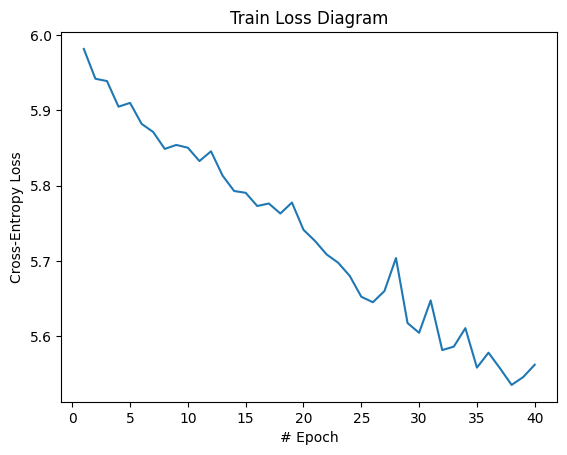

In [23]:
xpoints = np.arange(1, N_EPOCHS+1)
ypoints = train_loss_epochs

plt.plot(xpoints, ypoints)

plt.title("Train Loss Diagram")
plt.xlabel("# Epoch")
plt.ylabel("Cross-Entropy Loss")

plt.show()

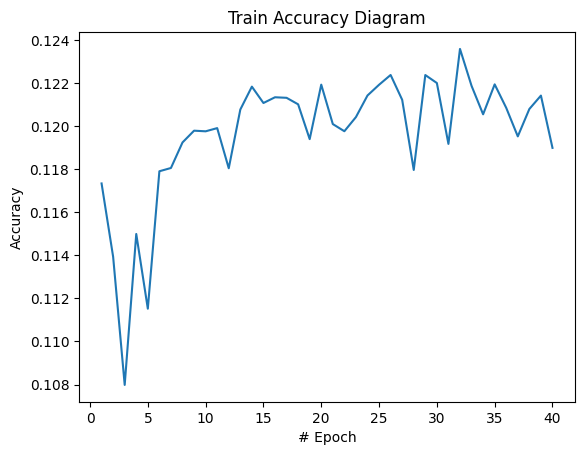

In [24]:
xpoints = np.arange(1, N_EPOCHS+1)
ypoints = train_accuracy_epochs

plt.plot(xpoints, ypoints)

plt.title("Train Accuracy Diagram")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")

plt.show()

### Model Testing

In [25]:
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f}')
print(f'| Test Accuracy: {100 * test_accuracy:.2f}%')

| Test Loss: 6.416
| Test Accuracy: 10.17%


In [26]:
random_index = random.randint(0, len(test_dataset))

print(f"Current Beyt: {test_dataset.data.loc[random_index,'Input']}")
print(f"Next: {test_dataset.data.loc[random_index,'Output']}")

Current Beyt: چو خامش بود جان شرمست و بس / چنو در زمانه ندیدست کس
Next: سپهبد نژادست و یزدان پرست / دل شرم و پرهیز دارد به دست


In [27]:
dic = test_dataset[random_index]
input = dic['Input']
output = dic['Output']

model.eval()

with torch.no_grad():
  src = input.to(device)
  src = torch.reshape(src, (len(src), 1))

  trg = output.to(device)
  trg = torch.reshape(trg, (len(trg), 1))

  output = model(src, trg, 0) #turn off teacher forcing

  output_dim = output.shape[-1]

  output = output[1:].view(-1, output_dim)
  trg = trg[1:].view(-1)

  output = (output.argmax(dim=1))

print(f'Predicted Next Beyt:')

for i in range(len(output)):
  print(train_dataset.vocab.itos[output[i].item()])

Predicted Next Beyt:
که
گفت
و
و
و
/
/
که
از
و
و
<EOS>
<EOS>
<EOS>


# **Part (B) - Bidirectional GRU**

### Encoder

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Based on the paper [2] it is usefulful to add an attention layer. This will take in the previous hidden state of the decoder, and all of the stacked forward and backward hidden states from the encoder.

Intuitively, this layer takes what we have decoded so far, and all of what we have encoded, to produce a vector, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode.

In [29]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

In [30]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### Training the Seq2Seq Model

In [32]:
TRG_PAD_IDX = train_dataset.PAD_IDX

INPUT_DIM = dictionary_size
OUTPUT_DIM = dictionary_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [33]:
# Weight initialization scheme suggested in the paper
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9171, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(9171, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=9171, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Number of parameters

In [34]:
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

The model has 27,572,435 trainable parameters


### Model Training

In [35]:
N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

train_loss_epochs = np.zeros(N_EPOCHS)
train_accuracy_epochs = np.zeros(N_EPOCHS)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train(model, train_dataloader, optimizer, criterion, CLIP)

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_epochs[epoch] = train_loss
    train_accuracy_epochs[epoch] = train_accuracy

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTrain Accuracy: {100 * train_accuracy:.2f}%')

Epoch: 01 | Time: 0m 13s
	Train Loss: 6.079
	Train Accuracy: 11.23%
Epoch: 02 | Time: 0m 13s
	Train Loss: 6.010
	Train Accuracy: 10.85%
Epoch: 03 | Time: 0m 13s
	Train Loss: 5.917
	Train Accuracy: 11.74%
Epoch: 04 | Time: 0m 13s
	Train Loss: 5.921
	Train Accuracy: 11.57%
Epoch: 05 | Time: 0m 13s
	Train Loss: 5.852
	Train Accuracy: 11.70%
Epoch: 06 | Time: 0m 13s
	Train Loss: 5.793
	Train Accuracy: 11.85%
Epoch: 07 | Time: 0m 13s
	Train Loss: 5.766
	Train Accuracy: 11.61%
Epoch: 08 | Time: 0m 13s
	Train Loss: 5.713
	Train Accuracy: 11.67%
Epoch: 09 | Time: 0m 13s
	Train Loss: 5.628
	Train Accuracy: 12.05%
Epoch: 10 | Time: 0m 13s
	Train Loss: 5.551
	Train Accuracy: 11.78%
Epoch: 11 | Time: 0m 13s
	Train Loss: 5.372
	Train Accuracy: 12.07%
Epoch: 12 | Time: 0m 13s
	Train Loss: 5.232
	Train Accuracy: 12.06%
Epoch: 13 | Time: 0m 13s
	Train Loss: 4.999
	Train Accuracy: 12.71%
Epoch: 14 | Time: 0m 13s
	Train Loss: 4.791
	Train Accuracy: 13.31%
Epoch: 15 | Time: 0m 13s
	Train Loss: 4.434
	Tra

### Loss & Accuracy Diagrams

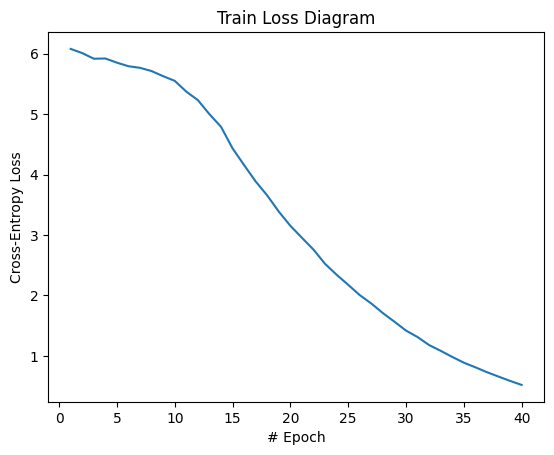

In [36]:
xpoints = np.arange(1, N_EPOCHS+1)
ypoints = train_loss_epochs

plt.plot(xpoints, ypoints)

plt.title("Train Loss Diagram")
plt.xlabel("# Epoch")
plt.ylabel("Cross-Entropy Loss")

plt.show()

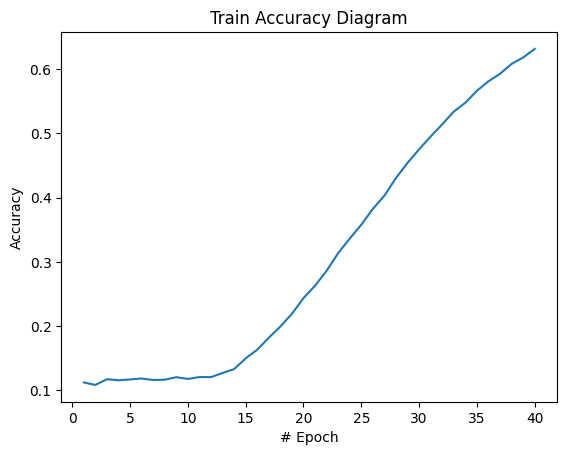

In [37]:
xpoints = np.arange(1, N_EPOCHS+1)
ypoints = train_accuracy_epochs

plt.plot(xpoints, ypoints)

plt.title("Train Accuracy Diagram")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")

plt.show()

### Model Testing

In [38]:
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f}')
print(f'| Test Accuracy: {100 * test_accuracy:.2f}%')

| Test Loss: 9.879
| Test Accuracy: 5.44%


In [39]:
random_index = random.randint(0, len(test_dataset))

print(f"Current Beyt: {test_dataset.data.loc[random_index,'Input']}")
print(f"Next: {test_dataset.data.loc[random_index,'Output']}")

Current Beyt: ز ایران بیامد دمادم سپاه / ز راه بیابان سوی رزمگاه
Next: ز لشکر به لشکر دو فرسنگ ماند / سپهبد جهاندیدگان را بخواند


In [40]:
dic = test_dataset[random_index]
input = dic['Input']
output = dic['Output']

model.eval()

with torch.no_grad():
  src = input.to(device)
  src = torch.reshape(src, (len(src), 1))

  trg = output.to(device)
  trg = torch.reshape(trg, (len(trg), 1))

  output = model(src, trg, 0) #turn off teacher forcing

  output_dim = output.shape[-1]

  output = output[1:].view(-1, output_dim)
  trg = trg[1:].view(-1)

  output = (output.argmax(dim=1))

print(f'Predicted Next Beyt:')

for i in range(len(output)):
  print(train_dataset.vocab.itos[output[i].item()])

Predicted Next Beyt:
چو
گنج
و
لشکر
و
دیبای
چین
/
چنان
لشکری
و
ز
لشکر


# Results

By comparing the results of the first and second parts, it can be seen that the GRU model gave better results than the LSTM model on our problem.